In [37]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker 

from nltk.util import ngrams
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [38]:
# Get cleaned data
df = pd.read_csv("cleaned_transaction_data.csv")

In [39]:
df.head()

,Posting Date,Transaction Type,Amount,Description,Transaction Category
0,4/28/2023,Debit,-20.48,trader jo trader joes,NaN
1,4/26/2023,Debit,-11.78,doordash dashmart street,NaN
2,4/25/2023,Debit,-5.99,trader jo trader joes,NaN
3,4/25/2023,Debit,-19.00,target hoove,Shopping & Groceries
4,4/24/2023,Debit,-9.05,trader jo trader joes,NaN


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Posting Date          686 non-null    object 
 1   Transaction Type      686 non-null    object 
 2   Amount                686 non-null    float64
 3   Description           686 non-null    object 
 4   Transaction Category  142 non-null    object 
dtypes: float64(1), object(4)
memory usage: 26.9+ KB


In [41]:
df.columns

Index(['Posting Date', 'Transaction Type', 'Amount', 'Description',
       'Transaction Category'],
      dtype='object')

In [42]:
# make "Transaction Category" as type category
df['Transaction Category'] = df['Transaction Category'].astype('category')

In [43]:
df_train = df[df['Transaction Category'].notnull()]
df_test = df[df['Transaction Category'].isnull()]

In [44]:
df_train["Transaction Category"].value_counts()

Shopping & Groceries    103
Food & Dining            33
Recreation                3
Business Services         1
Health & Fitness          1
Transportation            1
Name: Transaction Category, dtype: int64

Check in each category in the training data if everything is labelled correctly

In [45]:
# Make a function for rechecking if the category is correct
def check_if_cat_correct(df,category_name):
    return df[df['Transaction Category'] == category_name ]['Description']


### Transportation

In [46]:
check_if_cat_correct(df_train,'Transportation')

570     napa farms market tg sfo intl terarea g 
Name: Description, dtype: object

In [47]:
# shift this to Shopping & Groceries
df_train.at[570,"Transaction Category"] = "Shopping & Groceries"

### Business Services

In [48]:
check_if_cat_correct(df_train,'Business Services')

566     fedex airways  memphis 
Name: Description, dtype: object

In [49]:
# Make another category Miscellaneous by replacing Business Services
df_train['Transaction Category'] = df_train['Transaction Category'].cat.rename_categories({'Business Services':'Miscellaneous'})

/var/folders/2x/drm3ntdx17b_bz5f93_x9zjw0000gn/T/ipykernel_97513/541668281.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Transaction Category'] = df_train['Transaction Category'].cat.rename_categories({'Business Services':'Miscellaneous'})


### Health & Fitness

In [50]:
check_if_cat_correct(df_train,'Health & Fitness')

248       walgreens hollywo   
Name: Description, dtype: object

In [51]:
# this should be in 'Shopping & Groceries'
df_train.at[248,"Transaction Category"] = "Shopping & Groceries"

### Recreation

In [52]:
check_if_cat_correct(df_train,'Recreation')

192                           supercuts vermont    c 
296                           supercuts vermont    c 
458       bath body works glendale galleria glendale 
Name: Description, dtype: object

### Food & Dining

In [53]:
check_if_cat_correct(df_train,'Food & Dining').unique()

array([' dominos    angel ', ' dominos   ',
       ' starbucks store e colorado  ', ' subway     ',
       ' starbucks store   l ', ' chipotle santa monica blv beve ',
       ' subway  street  ', ' doordashpapa johns pi  streetsuite ',
       ' doordashburger king  streetsuite ', ' chickfila    '],
      dtype=object)

### Shopping & Groceries

In [54]:
check_if_cat_correct(df_train,'Shopping & Groceries').unique()

array(['   target  hoove   ', '   target store      ',
       ' amazon primehyorl terry  n amz ',
       ' amazon primehdsvxc terry  n amz ',
       ' amazon primeiulip terry  n amz ',
       ' amazon primefkadih terry  n amz ', '   gap outlet us commerce ',
       '   walgreens hollywo   ', '   marshalls firestone   gate ',
       '   walmart firestone   gate ', '   panda express universal cit ',
       ' amazon primeprel terry  n amz ', '   target store     ',
       ' amazon primeqhgq terry  n amz ',
       ' amazon primeeri terry  n amz ',
       'recurring  amazon primeivpma terry  n amz ',
       '   target store   unit   ',
       ' napa farms market tg sfo intl terarea g ', '   nordstrom  rd   ',
       '   target     '], dtype=object)

In [55]:
# train data is too less, we need to label some in test data as well
print(df_train.shape,df_test.shape)

(142, 5) (544, 5)


### Label some part of test data

In [56]:
# lets see the ngrams for the test data to label it correctly
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                        for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

Top 2 ngrams


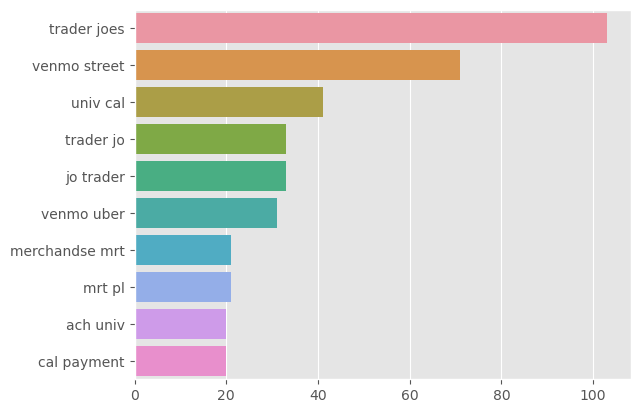

Top 3 ngrams


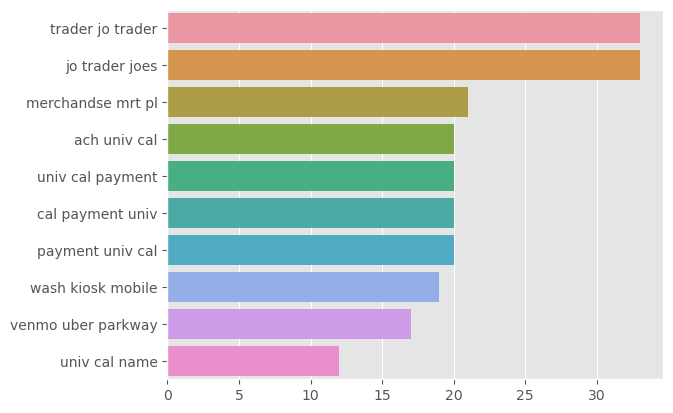

Top 4 ngrams


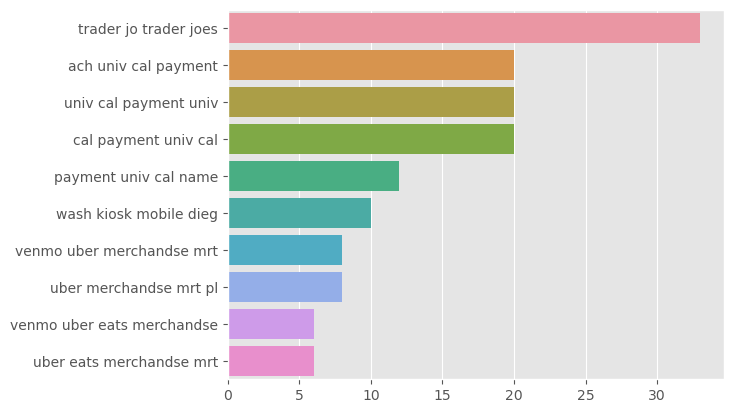

Top 5 ngrams


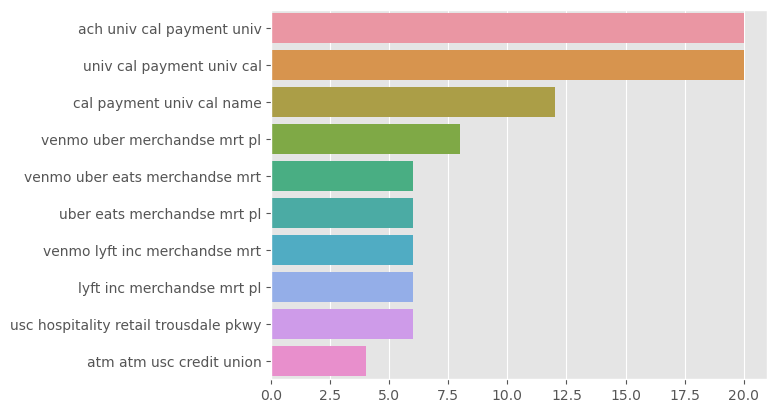

Top 6 ngrams


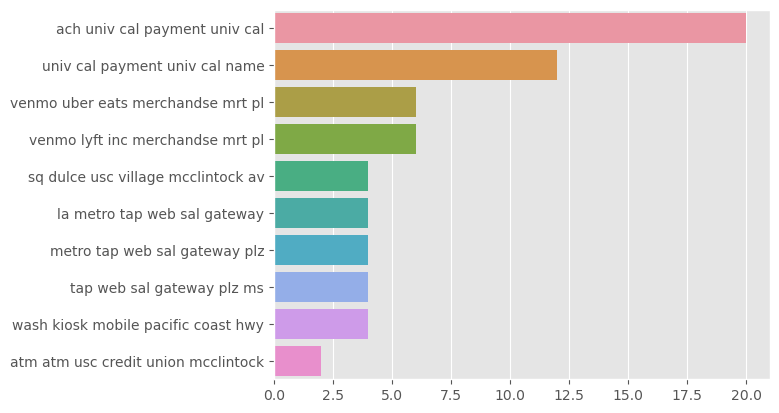

In [57]:
for i in range(2,7):
    print("Top {} ngrams".format(i))
    plot_top_ngrams_barchart(df_test['Description'],i)
    plt.show()

In [58]:
for i in ["ralphs","amazon","trader jo trader joes","trader joes","venmo"]:
    print(df_test.loc[df_test['Description'].str.contains(re.escape(i), case=False)]['Description'].unique())

[' ralphs vermont   angele ' ' ralphs vermont  ' '   ralphs verm   ']
['   amazoncomhjwpwq seattle ' '   amazoncomhjxibc seattle '
 '   amazoncomhjzgn seattle ' '   amazoncomhdprt seattle '
 '   amazoncomhrpc seattle ' '   amazoncomhhmm seattle '
 '   amazoncomjolbai seattle ' '   amazoncomxikd seattle '
 '   amazoncomqdfy seattle ' '   amazoncomgfal seattle '
 '   amazoncomhwleg seattle ' '   amazoncomkmob seattle '
 '   amazoncomkqfgn seattle ' '   amazoncomebv seattle '
 '   amazoncomxslo seattle ' '   amazoncommb seattle '
 '   amazoncomfxaqj seattle ' '   amazoncomjjau seattle '
 '   amazoncomnutyj seattle ' '   amazoncomywbjf seattle '
 '   amazoncombddk seattle ' '   amazoncomshexh seattle '
 '   amazoncomevra seattle ' '   amazoncomcvav seattle '
 ' bill payment jjmersww bp amazoncom amazoncomnxcp us'
 ' bill payment ooizesp bp amazoncom amazoncomte us'
 ' bill payment fakdesbgbc bp amazoncom amazoncompnehr us'
 ' bill payment tlpjcqu bp amazoncom amazoncombxhx us'
 '  ates  am

In [59]:
for i in ["ralphs","amazon","trader jo trader joes","trader joes","venmo"]:
    df_test.loc[df_test['Description'].str.contains(re.escape(i), case=False), 'Transaction Category'] = 'Shopping & Groceries'

In [60]:
# make new category "Tuition & Rent" in "Transation Category" for univ cal
df_test["Transaction Category"] = df_test["Transaction Category"].cat.add_categories("Tuition & Rent")

/var/folders/2x/drm3ntdx17b_bz5f93_x9zjw0000gn/T/ipykernel_97513/2697105111.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Transaction Category"] = df_test["Transaction Category"].cat.add_categories("Tuition & Rent")


In [61]:
for i in ["univ cal"]:
    print(df_test.loc[df_test['Description'].str.contains(re.escape(i), case=False)]["Description"].unique())

[' ach univ cal  payment  univ cal name ' ' overdrawn amount univ cal'
 ' ach univ cal  payment  univ cal']


In [62]:
for i in ["univ cal"]:
    df_test.loc[df_test['Description'].str.contains(re.escape(i), case=False), 'Transaction Category'] = 'Tuition & Rent'

In [63]:
for i in ["uber","lyft"]:
    print(df_test.loc[df_test['Description'].str.contains(re.escape(i), case=False)]["Description"].unique())

[' venmo uber  parkway ' ' venmo uber  merchandse mrt pl '
 ' venmo uber eats  merchandse mrt pl ']
[' lyft ride mon berry   ' ' lyft ride market   ' ' lyft ride berry   '
 ' lyft ride tue pm berry   ' ' lyft ride thu pm berry   '
 ' lyft rides berry   ' ' lyft cancel fee berry   '
 ' venmo lyft inc  merchandse mrt pl '
 ' lyft lyft rentals berry street  fr ']


In [64]:
# print description for uber and lyft but not description containing uber eats
# Filter the rows containing 'Uber' or 'Lyft' in the description
df_test.loc[df_test['Description'].str.contains('uber|lyft', case=False), 'Transaction Category'] = 'Transportation'

In [65]:
# while labeling venmo as shopping and groceries, we also need to label uber eats and doordash as food and dining
df_test.loc[df_test['Description'].str.contains('uber eats', case=False), 'Transaction Category'] = 'Food & Dining'
df_test.loc[df_test['Description'].str.contains('doordash', case=False), 'Transaction Category'] = 'Food & Dining'

#### We can see there wash kiosk statements in the ngrams, create another category called laundry

In [66]:
df_test["Transaction Category"] = df_test["Transaction Category"].cat.add_categories("Laundry")

/var/folders/2x/drm3ntdx17b_bz5f93_x9zjw0000gn/T/ipykernel_97513/3589338134.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Transaction Category"] = df_test["Transaction Category"].cat.add_categories("Laundry")


In [67]:
for i in ["wash"]:
    print(df_test.loc[df_test['Description'].str.contains(re.escape(i), case=False)]["Description"].unique())

[' wash laundry kiosk   torranc ' ' wash kiosk mobile    dieg '
 ' wash kiosk mobile    diego ' ' wash kiosk mobile n pacific coast hwy ']


In [68]:
for i in ["wash"]:
    df_test.loc[df_test['Description'].str.contains(i, case=False),'Transaction Category'] = "Laundry"

In [69]:
# combine the two dataframes
df = pd.concat([df_train,df_test])

In [70]:
df_train = df[df['Transaction Category'].notnull()]
df_test = df[df['Transaction Category'].isnull()]

In [71]:
print(df_train.shape,df_test.shape)

(517, 5) (169, 5)


In [72]:
df.to_csv("pre_processed_data.csv", index=False)

We have enough training data now